# 📘 Soal 1: Pengumpulan Data (Web Scraping)

## 🎯 Tujuan
Mengumpulkan data review dari aplikasi Google Play Store menggunakan teknik web scraping, kemudian menyimpan data tersebut dalam format JSON dan CSV untuk analisis lebih lanjut.

### 1️⃣ Persiapan: Pustaka yang Digunakan

Untuk scraping data dari Google Play Store, pustaka yang digunakan adalah:

- [`google-play-scraper`](https://pypi.org/project/google-play-scraper/)

**Alasan pemilihan:**
- Tidak perlu scraping manual dari HTML, karena pustaka ini menggunakan API internal Google Play.
- Mudah digunakan, efisien, dan tidak melanggar TOS Google selama penggunaannya terbatas dan untuk keperluan edukasi/riset.

**Instalasi:**
```bash
pip install google-play-scraper

In [1]:
!pip install google_play_scraper

^C


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
import json
import csv

### 2️⃣ Akses dan Ekstraksi Data Review

- Fungsi utama: `reviews()`  
- Parameter penting:
  - `app_id`: ID aplikasi di Play Store (saya memilih aplikasi `'com.tencent.ig'` PUBG Mobile)
  - `lang`, `country`: Bahasa dan negara review
  - `sort`: Urutan review (misalnya `MOST_RELEVANT` atau `NEWEST`)
  - `count`: Jumlah review yang diambil

**Elemen-elemen yang diekstrak dari review:**
- `reviewId`: ID unik dari review
- `content`: Isi atau teks review
- `score`: Skor rating (1–5 bintang)
- `userName`: Nama pengguna yang memberi review
- `at`: Tanggal review
- `replyContent`: Balasan dari developer (jika ada)


In [ ]:
result, continuation_token = reviews(
    'com.tencent.ig',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=15,
    filter_score_with=None
)

data = [{'id': r['reviewId'], 'review': r['content']} for r in result]

### 3️⃣ Penyimpanan Data

Setelah data terkumpul, data disimpan dalam dua format:

- **JSON** → Fleksibel, mudah dibaca, dan cocok untuk aplikasi berbasis web/API.
- **CSV** → Sangat cocok untuk digunakan dalam analisis data (Excel, Pandas, dll).

**Struktur data json:**
```json
{
  "id": "reviewId123",
  "review": "This is the content of the review."
}
```
**Struktur data csv:**
```csv
id,review
```


In [ ]:
with open('pubg_reviews.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2, ensure_ascii=False)

with open('pubg_reviews.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'review'])
    writer.writeheader()
    writer.writerows(data)

for item in data:
    print(f"ID: {item['id']}\nReview: {item['review']}\n")

ID: 67585c5d-bdc2-432e-b6bd-a4c9d8bc4158
Review: teruntuk devloper, semua nya dudah bagus, dari event nya yg menarik.dan juga tambahan ditur yang keren. tetapi kalau bisa, permudahkan lah suasana gameplay seperti dioptimalkan grafik dan frame fps, dan juga panas nya untuk hp kelas menengah dan bawah. karna sangat berpengaruh untuk kenyamanann bermain.sebener nya olayer nya bisa lebih banyak lagi jika pihak mengoptimalisasikan grafik, frame drop supaya hape kelas bawah menengah bisa bermain, itu saja.sekian.

ID: b0db4bd2-2dc1-4f6d-930e-24bb7ca958e0
Review: Meski tidak bisa mendapat pengalaman bermain yang maksimal, terkait perangkat yang masih level medium, tapi lumayan dibanding 1-2 tahun kemarin. Artinya sekarang terkait pengalqman bermain saya sudah puas. Cuman ada 1 saran saya, kalau bisa kembalikan sistem bermain yg nuansa real pubg clasik, sebab dengan adanya skill-skill tambahan pubg malah kayak FF. Nuansa clasic jauh lebih dirindukan & diinginkan semua pemain. Thanks

ID: e76b5

# 📘 Soal 2: Preprocessing Data

## 🎯 Tujuan
Melakukan preprocessing terhadap data review aplikasi untuk menyiapkan data yang bersih dan siap dianalisis.

### Library

disini saya menggunakan stanza(id & en) untuk melakukan pemrosesan data teks

In [ ]:
!pip install stanza

In [ ]:
import stanza

stanza.download('id')
stanza.download('en')

nlp_id = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma,depparse')
nlp_en = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse', tokenize_pretokenized=False)

### 1️⃣ Pembersihan Teks
Menghapus simbol, angka, dan tanda baca yang tidak diperlukan. Juga dilakukan normalisasi karakter unicode dan whitespace.

In [ ]:
import re
import string

def bersihkan_teks(teks):
    teks = teks.lower() # Mengubah seluruh huruf menjadi huruf kecil agar konsisten
    teks = re.sub(r'([,.])', r' \1 ', teks) # Menambahkan spasi di sekitar tanda koma , dan titik . agar dianggap sebagai token terpisah saat tokenisasi.
    teks = re.sub(r'([\U0001F600-\U0001F64F])', r' \1 ', teks) # Menambahkan spasi di sekitar emoji wajah (emotikon) dari Unicode range U+1F600 hingga U+1F64F, agar emoji tidak melekat ke kata dan bisa di-tokenisasi dengan baik.
    teks = re.sub(r'\d+', '', teks) # Menghapus angka (1, 2023, dsb.) dari teks.
    teks = teks.translate(str.maketrans('', '', string.punctuation)) # Menghapus semua tanda baca ASCII standar (seperti !@#(), dsb.) dari teks.
    teks = re.sub(r'[^\w\s]', '', teks) # Menghapus karakter yang bukan huruf, angka, atau spasi, termasuk simbol-simbol Unicode yang tidak diinginkan
    teks = re.sub(r'\s+', ' ', teks).strip() # Menghapus spasi ganda atau lebih menjadi satu spasi, lalu menghapus spasi di awal/akhir teks.
    teks = re.sub(r'[\u00B2\u00B3\u2070-\u209F]', ' ', teks) # Menghapus karakter Unicode superscript/subscript seperti ², ³, atau angka-angka kecil matematika (², ⁰, ₁, dsb.).

    return teks

for item in data:
    teks = item['review']
    teks_bersih = bersihkan_teks(teks)
    print(f"Review Asli: {item['review']}\nReview Bersih: {teks_bersih}\n")
    item['review_bersih'] = teks_bersih

Review Asli: teruntuk devloper, semua nya dudah bagus, dari event nya yg menarik.dan juga tambahan ditur yang keren. tetapi kalau bisa, permudahkan lah suasana gameplay seperti dioptimalkan grafik dan frame fps, dan juga panas nya untuk hp kelas menengah dan bawah. karna sangat berpengaruh untuk kenyamanann bermain.sebener nya olayer nya bisa lebih banyak lagi jika pihak mengoptimalisasikan grafik, frame drop supaya hape kelas bawah menengah bisa bermain, itu saja.sekian.
Review Bersih: teruntuk devloper semua nya dudah bagus dari event nya yg menarik dan juga tambahan ditur yang keren tetapi kalau bisa permudahkan lah suasana gameplay seperti dioptimalkan grafik dan frame fps dan juga panas nya untuk hp kelas menengah dan bawah karna sangat berpengaruh untuk kenyamanann bermain sebener nya olayer nya bisa lebih banyak lagi jika pihak mengoptimalisasikan grafik frame drop supaya hape kelas bawah menengah bisa bermain itu saja sekian

Review Asli: Meski tidak bisa mendapat pengalaman be

### 2️⃣ Tokenisasi Teks Bersih
Memecah teks bersih menjadi token-token kata.

In [ ]:
for item in data:
    text = item['review_bersih']
    doc = nlp_id(text)
    tokens = []

    for sentence in doc.sentences:
        for token in sentence.tokens:
            tokens.append(token.text)

    item['token_bersih'] = tokens

### 3️⃣ Stopword Removal
Menghapus kata-kata yang umum dan tidak membawa informasi penting dari token.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_id = set(stopwords.words('indonesian'))
stop_words_en = set(stopwords.words('english'))

stop_words_asset = set([
    'nya', 'yg', 'jga', 'cuman', 'g', 'bngt', 'tpi', 'sekian', 'banget', 'karna', 'sih', 'aja', 'gamenya', 'terus', 'pada',
    'untuk', 'bisa', 'ga', 'dan', 'di', 'dari', 'terlalu', 'lebih', 'kenapa', 'pas', 'sama', 'aja', 'saya', 'ke', 'yg',
    'ketika', 'ini', 'kalau', 'sudah', 'bisa', 'lebih', 'lagi', 'kita', 'buat', 'diatas', 'sudah', 'baik', 'padahal',
    'saat', 'langsung', 'disitu', 'ada', 'sama', 'sangat', 'banyak', 'langsung', 'lagi', 'saya', 'kecewa', 'mau', 'gini',
    'terasa', 'mending', 'ini', 'untuk', 'tambah', 'dan', 'ada', 'tambahin', 'ga', 'bisa', 'belum'
])

In [ ]:
def remove_stopwords(tokens):
    filtered_tokens = []

    for word in tokens:
        if word.lower() in stop_words_id:
            continue
        elif word.lower() in stop_words_en:
            continue
        elif word.lower() in stop_words_asset:
            continue

        filtered_tokens.append(word)

    return " ".join(filtered_tokens)

for item in data:
    token = item['token_bersih']
    token_bersih = remove_stopwords(token)
    teks = item['review_bersih']
    print(f"Review Asli: {teks}\nReview Stopword: {token_bersih}\n")
    item['review_stopword'] = token_bersih

Review Asli: teruntuk devloper semua nya dudah bagus dari event nya yg menarik dan juga tambahan ditur yang keren tetapi kalau bisa permudahkan lah suasana gameplay seperti dioptimalkan grafik dan frame fps dan juga panas nya untuk hp kelas menengah dan bawah karna sangat berpengaruh untuk kenyamanann bermain sebener nya olayer nya bisa lebih banyak lagi jika pihak mengoptimalisasikan grafik frame drop supaya hape kelas bawah menengah bisa bermain itu saja sekian
Review Stopword: teruntuk devloper dudah bagus event menarik tambahan ditur keren permudahkan suasana gameplay dioptimalkan grafik frame fps panas hp kelas menengah berpengaruh kenyamanann bermain sebener olayer mengoptimalisasikan grafik frame drop hape kelas menengah bermain

Review Asli: meski tidak bisa mendapat pengalaman bermain yang maksimal terkait perangkat yang masih level medium tapi lumayan dibanding tahun kemarin artinya sekarang terkait pengalqman bermain saya sudah puas cuman ada saran saya kalau bisa kembalikan

### 4️⃣ Tokenisasi Teks Stopword
Memecah teks stopword menjadi token-token kata.

In [ ]:
for item in data:
    text = item['review_stopword']
    doc = nlp_id(text)
    tokens = []

    for sentence in doc.sentences:
        for token in sentence.tokens:
            tokens.append(token.text)

    item['token_stopword'] = tokens

### 5️⃣ Lemmatization
Dalam kasus ini, **lemmatization** lebih baik dibandingkan stemming karena saya ingin mempertahankan makna dari kata aslinya. Stemming bisa terlalu agresif dan mengubah arti kata. Lemmatization lebih akurat dalam NLP modern.


In [ ]:
def lemmatize_token(text):
    doc_id = nlp_id(text)
    lemmas_id = [word.lemma for sent in doc_id.sentences for word in sent.words if word.lemma and word.lemma != 'None']
    return " ".join(lemmas_id)

for item in data:
    teks = item['review_stopword']
    teks_lemmatization = lemmatize_token(teks)

    print(f"Review Asli: {teks}\nReview Asli: {teks_lemmatization}\n")
    item['review_lemmatization'] = teks_lemmatization

Review Asli: teruntuk devloper dudah bagus event menarik tambahan ditur keren permudahkan suasana gameplay dioptimalkan grafik frame fps panas hp kelas menengah berpengaruh kenyamanann bermain sebener olayer mengoptimalisasikan grafik frame drop hape kelas menengah bermain
Review Asli: teruntuk devloper dudah bagus event menarik tambah ditur keren mudah suasana gameplay optimal grafik frame fps panas hp kelas menengah pengaruh kenyamanann main sebener olayer koptimalisasi grafik frame drop hape kelas menengah main

Review Asli: pengalaman bermain maksimal terkait perangkat level medium lumayan dibanding kemarin terkait pengalqman bermain puas saran kembalikan sistem bermain nuansa real pubg clasik skillskill tambahan pubg kayak ff nuansa clasic dirindukan pemain thanks
Review Asli: pengalaman main maksimal kait perangkat level medium lumayan banding kemarin kait pengalqman main puas saran balik sistem main nuansa real pubg clasik skillskill tambah pubg kayak ff nuansa clasic rindu main

### 6️⃣ Tokenisasi Teks Lemmatization
Memecah teks lemmatization menjadi token-token kata.

In [ ]:
for item in data:
    text = item['review_lemmatization']
    doc = nlp_id(text)
    tokens = []

    for sentence in doc.sentences:
        for token in sentence.tokens:
            tokens.append(token.text)

    item['token_lemmatization'] = tokens

### 7️⃣ Finalisasi Data

In [ ]:
print(data[0].keys())

dict_keys(['id', 'review', 'review_bersih', 'token_bersih', 'review_stopword', 'token_stopword', 'review_lemmatization', 'token_lemmatization'])


Data yang akan digunakan hanya berisi:
- `id`
- `review_lemmatization`
- `token_lemmatization`

karena data itu sudah melalui process cleaning, tokenization, stopword, dan lemmatization

In [ ]:
processed_data = [
    {
        'id': item['id'],
        'review': item['review_lemmatization'],
        'token': item['token_lemmatization']
    }
    for item in data
]

In [ ]:
with open('processed_data.json', 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, indent=2, ensure_ascii=False)

with open('processed_data.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'review','token'])
    writer.writeheader()
    writer.writerows(processed_data)

for item in processed_data:
    print(f"ID: {item['id']}\nReview: {item['review']}\nToken: {item['token']}\n")

ID: 67585c5d-bdc2-432e-b6bd-a4c9d8bc4158
Review: teruntuk devloper dudah bagus event menarik tambah ditur keren mudah suasana gameplay optimal grafik frame fps panas hp kelas menengah pengaruh kenyamanann main sebener olayer koptimalisasi grafik frame drop hape kelas menengah main
Token: ['teruntuk', 'devloper', 'dudah', 'bagus', 'event', 'menarik', 'tambah', 'ditur', 'keren', 'mudah', 'suasana', 'gameplay', 'optimal', 'grafik', 'frame', 'fps', 'panas', 'hp', 'kelas', 'menengah', 'pengaruh', 'kenyamanann', 'main', 'sebener', 'olayer', 'koptimalisasi', 'grafik', 'frame', 'drop', 'hape', 'kelas', 'menengah', 'main']

ID: b0db4bd2-2dc1-4f6d-930e-24bb7ca958e0
Review: pengalaman main maksimal kait perangkat level medium lumayan banding kemarin kait pengalqman main puas saran balik sistem main nuansa real pubg clasik skillskill tambah pubg kayak ff nuansa clasic rindu main thanks
Token: ['pengalaman', 'main', 'maksimal', 'kait', 'perangkat', 'level', 'medium', 'lumayan', 'banding', 'kemarin'

# 📘 Soal 3: Analisis Sentimen

## 🎯 Tujuan
analisis sentimen untuk menentukan apakah review tersebut bersifat positif, negatif, atau netral

## 1️⃣ Melakukan Analisis Sentimen Menggunakan Library VADER

In [ ]:
!pip install vaderSentiment deep-translator

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator

analyzer = SentimentIntensityAnalyzer()
translator = GoogleTranslator(source='auto', target='en')

In [ ]:
for item in processed_data:
    teks = item['review']
    scores = analyzer.polarity_scores(teks)

    if scores['compound'] >= 0.05:
        label = 'positive'
    elif scores['compound'] <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'

    print(f"ID: {item['id']}")
    print(f"Review: {teks}")
    print(f"Sentimen: {label}, Skor: {scores['compound']:.4f}\n")
    item['sentimen'] = label
    item['sentimen_skor'] = scores['compound']

ID: 67585c5d-bdc2-432e-b6bd-a4c9d8bc4158
Review: teruntuk devloper dudah bagus event menarik tambah ditur keren mudah suasana gameplay optimal grafik frame fps panas hp kelas menengah pengaruh kenyamanann main sebener olayer koptimalisasi grafik frame drop hape kelas menengah main
Sentimen: positive, Skor: 0.1027

ID: b0db4bd2-2dc1-4f6d-930e-24bb7ca958e0
Review: pengalaman main maksimal kait perangkat level medium lumayan banding kemarin kait pengalqman main puas saran balik sistem main nuansa real pubg clasik skillskill tambah pubg kayak ff nuansa clasic rindu main thanks
Sentimen: positive, Skor: 0.6908

ID: e76b5adc-0c2b-498f-b129-5866c2236700
Review: masuk match diluar rank map diluar event mode solo duo mohon fix match cepat rasa enggan main
Sentimen: neutral, Skor: 0.0000

ID: 99fb3b99-7abc-481d-af80-ed532b0bd911
Review: bintang performa hp kelas entry level berat grafis smooth ultra frame drop sinyal masalah signal bar pakai quota sekali nya sinyal dia bagus main jamhari sedot g

## 2️⃣ Hasil Analisis Sentimen Untuk Tiga Review yang Berbeda


### ➖ Neutral
ID: bffdacba-5b8a-4f9e-b063-b072328bd456

Review: game seru senang alang kah seru nya peta miramar tambah lorong tanah lengkap supali ruang rahasia tambah seru pecinta game blm tambah miramar turun seru dia pecinta game gedung panjat cari kendara terbang senang harap kedepan game bis lbh seru

Sentimen: neutral, Skor: 0.0000

### ❌ Negative
ID: 447b3124-134b-46b6-bc31-7abb85aaa830

Review: terang game bagus ngbug arena perang hilang koneksi nyambung tinggoy musuh udah ketembak kali kuat ane ketembak kali sekarat ngga fair pass melayang udara musuh udah dapet senjata otomatis darat kena kill males maen uy

Sentimen: negative, Skor: -0.5267

### ✅ Positive
ID: c655d9b5-30b7-4edf-9f16-161c01b58021

Review: menurutku bagus optimal bilang berat bro pake hp redmi note ram grafik full hd aman aman frame drop

Sentimen: positive, Skor: 0.1027

##3️⃣ Apa keuntungan dan kerugian menggunakan analisis sentimen otomatis dibandingkan dengan manual?

#### ✅ Keuntungan Analisis Sentimen Otomatis

1. **Cepat dan Efisien**  
   Mampu memproses ribuan hingga jutaan data teks dalam hitungan detik.

2. **Konsisten**  
   Tidak terpengaruh oleh kelelahan, emosi, atau bias manusia dalam pengambilan keputusan.

3. **Skalabilitas Tinggi**  
   Cocok untuk menangani big data seperti komentar media sosial, ulasan produk, dan survei.

4. **Biaya Lebih Rendah**  
   Setelah sistem dibangun, dapat berjalan otomatis tanpa banyak biaya operasional.

5. **Integrasi Mudah**  
   Dapat diintegrasikan langsung dengan sistem lain seperti dashboard monitoring atau chatbot.

---

#### ❌ Kerugian Analisis Sentimen Otomatis

1. **Kesulitan Memahami Konteks atau Sarkasme**  
   Model sering gagal menangkap makna sarkasme atau konteks kultural.

2. **Kesulitan Menangani Slang atau Typo**  
   Bahasa informal, kesalahan penulisan, atau singkatan lokal bisa mengganggu akurasi.

3. **Model Umum Tidak Selalu Cocok untuk Semua Domain**  
   Model generik tidak bisa memahami konteks spesifik seperti di dunia medis atau politik.

4. **Sangat Bergantung pada Kualitas Data**  
   Data noisy atau tidak bersih bisa menyebabkan hasil prediksi yang keliru.

5. **Tetap Membutuhkan Evaluasi Manual**  
   Untuk validasi dan pelatihan ulang model agar tetap akurat dan relevan.

---

#### 📌 Kesimpulan

- **Gunakan otomatisasi** untuk kebutuhan skala besar dan efisiensi waktu/biaya.
- **Gunakan manual** untuk akurasi tinggi, pemahaman konteks dalam, dan data yang sensitif.



#📘 Soal 4: Ekstraksi Entitas Menggunakan Aturan Produksi Tugas

## 🎯 Tujuan
mengekstrak informasi penting lainnya dari review, seperti nama aplikasi, versi, atau masalah yang dilaporkan

### 1️⃣ Penjelasan Aturan Produksi
Aturan produksi adalah metode berbasis pola (pattern matching) yang digunakan untuk mengekstrak informasi dari teks berdasarkan struktur sintaksis atau kata kunci tertentu.

Keunggulannya:
- Cepat dan efisien.
- Cocok untuk domain spesifik dengan pola tetap.

---

### 2️⃣ Contoh Aturan Produksi

#### Ekstraksi Masalah
Gunakan kata-kata kunci umum seperti: `panas` `drop` `ngelag` `enggan` `berat` `ngbug` `ngebug` `hilang` `bug`.

Contoh aturan:
- Jika ditemukan kata `bug` atau `ngelag`, tandai sebagai masalah.
- Jika kata `saya` atau `aku` menjadi `subjek (nsubj)` dari kata kerja negatif, tandai sebagai pengguna yang mengalami masalah.

---

### 3️⃣ Implementasi

In [ ]:
# Ambil teks dari data
reviews = [entry['review'] for entry in processed_data]
# Proses kalimat dengan Stanza
docs_stanza = [nlp_id(text) for text in reviews]
# Visualisasi dan ekstraksi informasi dengan Stanza
for i, doc_stanza in enumerate(docs_stanza):
    print(f"\n==== Review {i+1} ====")
    # Visualisasi hasil dependency parsing
    for sentence in doc_stanza.sentences:
        for word in sentence.words:
          print(f"{word.text} ({word.pos}) --> {word.deprel}")
    print("\n--- End of Review ---\n")


==== Review 1 ====
teruntuk (VERB) --> root
devloper (NOUN) --> obj
dudah (NOUN) --> compound
bagus (ADJ) --> amod
event (NOUN) --> compound
menarik (VERB) --> acl
tambah (VERB) --> xcomp
ditur (NOUN) --> obj
keren (ADJ) --> amod
mudah (ADJ) --> amod
suasana (NOUN) --> nmod
gameplay (NOUN) --> compound
optimal (ADJ) --> amod
grafik (NOUN) --> compound
frame (NOUN) --> compound
fps (NOUN) --> compound
panas (ADJ) --> amod
hp (NOUN) --> compound
kelas (NOUN) --> compound
menengah (NOUN) --> compound
pengaruh (NOUN) --> compound
kenyamanann (NOUN) --> compound
main (X) --> dep
sebener (NOUN) --> compound
olayer (NOUN) --> compound
koptimalisasi (NOUN) --> compound
grafik (NOUN) --> compound
frame (NOUN) --> compound
drop (X) --> dep
hape (NOUN) --> compound
kelas (NOUN) --> compound
menengah (NOUN) --> compound
main (VERB) --> acl

--- End of Review ---


==== Review 2 ====
pengalaman (NOUN) --> root
main (NOUN) --> compound
maksimal (ADJ) --> amod
kait (NOUN) --> compound
perangkat (NOU

In [ ]:
# Buat Aturan Produksi
import re

# Fungsi untuk mengekstrak siapa yang mengalami masalah
def extract_person(doc_stanza):
    persons = []
    for sentence in doc_stanza.sentences:
        for word in sentence.words:
            if word.deprel == 'nsubj' and word.pos in ['NOUN', 'PROPN', 'PRON']:
                persons.append(word.text)
    return persons

# Fungsi untuk mengekstrak masalah yang dihadapi
def extract_issue(doc_stanza):
    issues = []
    for sentence in doc_stanza.sentences:
        for word in sentence.words:
            if re.search(r'(panas|drop|ngelag|enggan|berat|ngbug|ngebug|hilang|bug)', word.text, re.IGNORECASE):
                issues.append(word.text)
    return issues

# Fungsi untuk mengekstrak kejadian atau situasi yang terjadi
def extract_event(doc_stanza):
    events = []
    for sentence in doc_stanza.sentences:
        for word in sentence.words:
            if word.deprel in ['obj', 'dobj'] and word.pos in ['NOUN', 'VERB']:
                events.append(word.text)
    return events

# Ekstraksi informasi dari setiap review
for i, doc_stanza in enumerate(docs_stanza):
    print(f"\n==== Review {i+1} ====")
    print(f"Review: {processed_data[i]['review']}")
    print(f"Sentimen: {processed_data[i]['sentimen']}")
    # Ekstraksi Siapa yang mengalami masalah
    persons = extract_person(doc_stanza)
    print(f"Siapa yang mengalami masalah: {', '.join(persons) if persons else 'Tidak ditemukan'}")

    # Ekstraksi Masalah
    issues = extract_issue(doc_stanza)
    print(f"Masalah yang dihadapi: {', '.join(issues) if issues else 'Tidak ditemukan'}")

    # Ekstraksi Kejadian atau Situasi
    events = extract_event(doc_stanza)
    print(f"Kejadian yang sering terjadi: {', '.join(events) if events else 'Tidak ditemukan'}")

    print("\n--- End of Review ---\n")



==== Review 1 ====
Review: teruntuk devloper dudah bagus event menarik tambah ditur keren mudah suasana gameplay optimal grafik frame fps panas hp kelas menengah pengaruh kenyamanann main sebener olayer koptimalisasi grafik frame drop hape kelas menengah main
Sentimen: positive
Siapa yang mengalami masalah: Tidak ditemukan
Masalah yang dihadapi: panas, drop
Kejadian yang sering terjadi: devloper, ditur

--- End of Review ---


==== Review 2 ====
Review: pengalaman main maksimal kait perangkat level medium lumayan banding kemarin kait pengalqman main puas saran balik sistem main nuansa real pubg clasik skillskill tambah pubg kayak ff nuansa clasic rindu main thanks
Sentimen: positive
Siapa yang mengalami masalah: Tidak ditemukan
Masalah yang dihadapi: Tidak ditemukan
Kejadian yang sering terjadi: Tidak ditemukan

--- End of Review ---


==== Review 3 ====
Review: masuk match diluar rank map diluar event mode solo duo mohon fix match cepat rasa enggan main
Sentimen: neutral
Siapa yang m

In [ ]:
import pandas as pd

extracted_data = []
for i, doc_stanza in enumerate(docs_stanza):
    persons = extract_person(doc_stanza)
    issues = extract_issue(doc_stanza)
    events = extract_event(doc_stanza)

    extracted_data.append({
        "Review ID": processed_data[i]['id'],
        "Review Text": reviews[i],
        "Who (Person)": ', '.join(persons) if persons else 'Tidak ditemukan',
        "Problem (Issue)": ', '.join(issues) if issues else 'Tidak ditemukan',
        "Event (Situation)": ', '.join(events) if events else 'Tidak ditemukan',
        "Sentimen": processed_data[i]['sentimen']
    })

df = pd.DataFrame(extracted_data)

df.to_csv("extracted_reviews.csv", index=False, encoding="utf-8-sig")
df.to_json("extracted_reviews.json", orient="records", indent=4, force_ascii=False)

# 📘Soal 5: Menggunakan Scanner untuk Pencocokan Pola Tugas

## 🎯 Tujuan
Untuk mendeteksi masalah atau bug yang sering dilaporkan oleh pengguna, Anda ingin menggunakan scanner untuk pencocokan pola dalam teks review

## 1️⃣ Apa itu scanner dalam konteks ekstraksi informasi?
Scanner adalah bagian yang memindai teks dan memecahnya menjadi tokentoken.
Dalam IE: Scanner ini mempersiapkan input bagi parser dengan mengenali jenis kata (entitas, kata kerja, lokasi, dsb)



## 2️⃣ Implementasi scanner untuk mencari kata tertentu

kita bisa menambahkan proses pencarian kata-kata tertentu (misalnya, "bug", "error", atau kata lainnya) pada teks yang ada dalam kolom Problem (Issue), Who (Person), dan Event (Situation) dari dataset.

## 3️⃣ Implementasi Scanner

In [6]:
from collections import Counter

with open('extracted_reviews.json', 'r', encoding='utf-8') as file:
    extracted_review = json.load(file)

texts = [item['Review Text'] for item in extracted_review]

keywords = ["bug", "frame", "berat", "drop"]

combined_text = " ".join(texts).lower()

word_counts = Counter(combined_text.split())

for keyword in keywords:
    print(f"'{keyword}': {word_counts[keyword]} kali")


'bug': 2 kali
'frame': 7 kali
'berat': 3 kali
'drop': 9 kali



Frekuensi Issue:
[('drop', 10), ('Tidak ditemukan', 5), ('berat', 4), ('bug', 3), ('frame', 1), ('panas', 1), ('enggan', 1), ('ngelag', 1)]

Frekuensi Person:
[('Tidak ditemukan', 5), ('dia', 5), ('developer', 2), ('rasa', 1), ('bintang', 1), ('game', 1), ('player', 1), ('pubg', 1), ('experience', 1), ('bug', 1), ('fps', 1), ('sensitivitas', 1)]

Frekuensi Event:
[('Tidak ditemukan', 2), ('data', 2), ('devloper', 1), ('ditur', 1), ('match', 1), ('quota', 1), ('jamhari', 1), ('histori', 1), ('event', 1), ('fps', 1), ('layout', 1), ('tibatiba', 1), ('sinyal', 1), ('game', 1), ('patahpatah', 1), ('pubg', 1), ('frame', 1), ('ping', 1), ('kompres', 1), ('cheer', 1), ('akibat', 1), ('menit', 1), ('downlod', 1), ('parasut', 1), ('bug', 1), ('musuh', 1), ('sensi', 1), ('update', 1), ('hd', 1)]


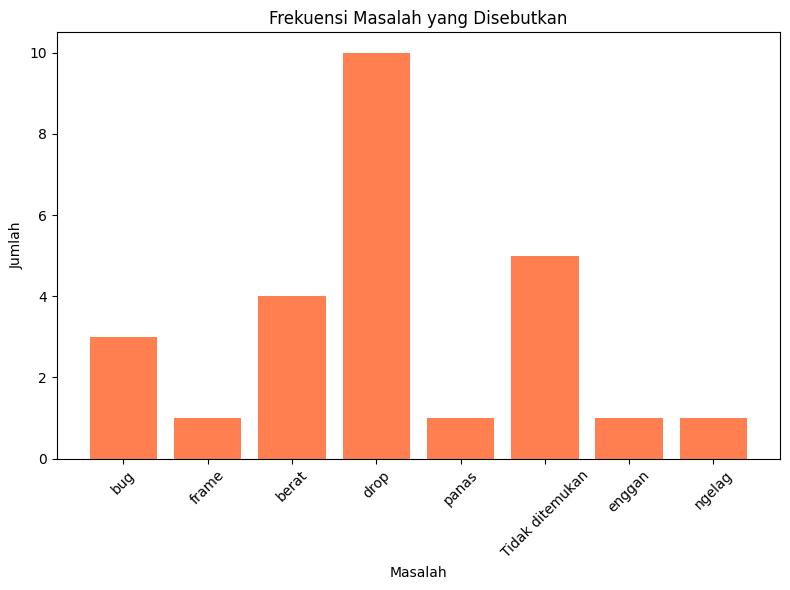

In [7]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# 1. SCANNER: Baca CSV
df = extracted_review

# 2. PARSER: Ekstrak issue, person, event
all_issues = ['bug', 'frame', 'berat', 'drop']
all_persons = []
all_events = []

for row in df:
    if pd.notnull(row['Problem (Issue)']):
        all_issues.extend(row['Problem (Issue)'].split(', '))
    if pd.notnull(row['Who (Person)']):
        all_persons.extend(row['Who (Person)'].split(', '))
    if pd.notnull(row['Event (Situation)']):
        all_events.extend(row['Event (Situation)'].split(', '))

# 3. TRANSLATOR: Hitung frekuensi
issue_counter = Counter(all_issues)
person_counter = Counter(all_persons)
event_counter = Counter(all_events)

# 4. EVALUATOR: Tampilkan hasil
print("\nFrekuensi Issue:")
print(issue_counter.most_common())
print("\nFrekuensi Person:")
print(person_counter.most_common())
print("\nFrekuensi Event:")
print(event_counter.most_common())

# 5. VISUALISASI: Issue paling sering
plt.figure(figsize=(8,6))
plt.bar(issue_counter.keys(), issue_counter.values(), color='coral')
plt.title('Frekuensi Masalah yang Disebutkan')
plt.xlabel('Masalah')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('frekuensi_issue.png')
plt.show()


# 📘 Soal 6: Visualisasi Hasil Analisis

##🎯 Tujuan
menvisualisasikan hasil extraksi agar mudah dipahami oleh stakeholders

In [9]:
df = pd.DataFrame(extracted_review)

def extract_terms(series):
    terms = []
    for item in series:
        if isinstance(item, str) and item.strip().lower() != "tidak ditemukan":
            terms.extend([term.strip() for term in item.split(',')])
    return terms

issue_counter = Counter(extract_terms(df["Problem (Issue)"]))
person_counter = Counter(extract_terms(df["Who (Person)"]))
event_counter = Counter(extract_terms(df["Event (Situation)"]))
sentiment_counter = Counter(df["Sentimen"])

def plot_counter(counter, title, xlabel, color):
    if not counter:
        print(f"Tidak ada data untuk {title}")
        return
    labels, values = zip(*counter.most_common())
    plt.figure(figsize=(8,5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 1️⃣ Visualisasi distribusi sentimen (positif, negatif, netral)

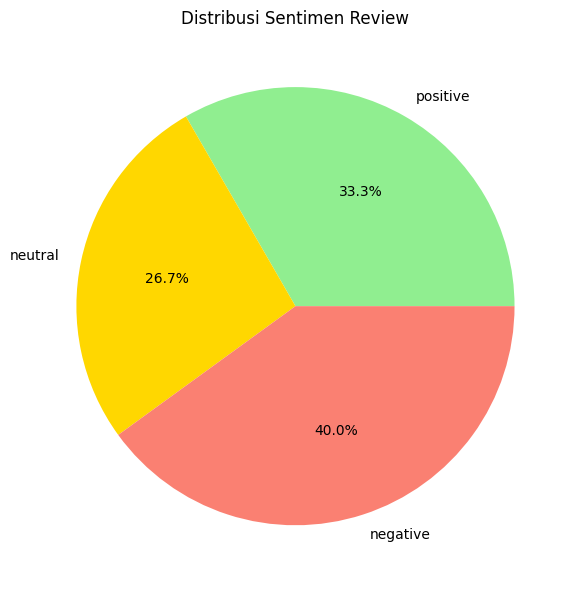

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(sentiment_counter.values(), labels=sentiment_counter.keys(), autopct='%1.1f%%', colors=['lightgreen', 'gold', 'salmon'])
plt.title("Distribusi Sentimen Review")
plt.tight_layout()
plt.show()

## 2️⃣ Visualisasi masalah yang paling sering ditemukan

### 📊Visualisasi Bar Chart

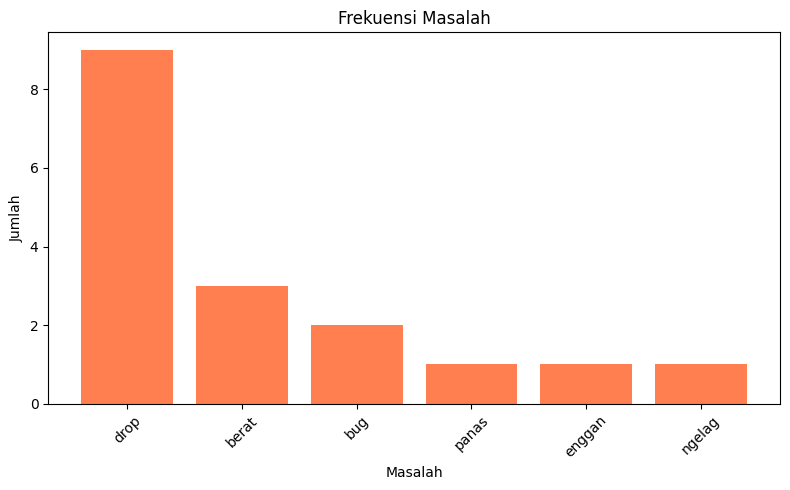

In [ ]:
plot_counter(issue_counter, "Frekuensi Masalah", "Masalah", "coral")

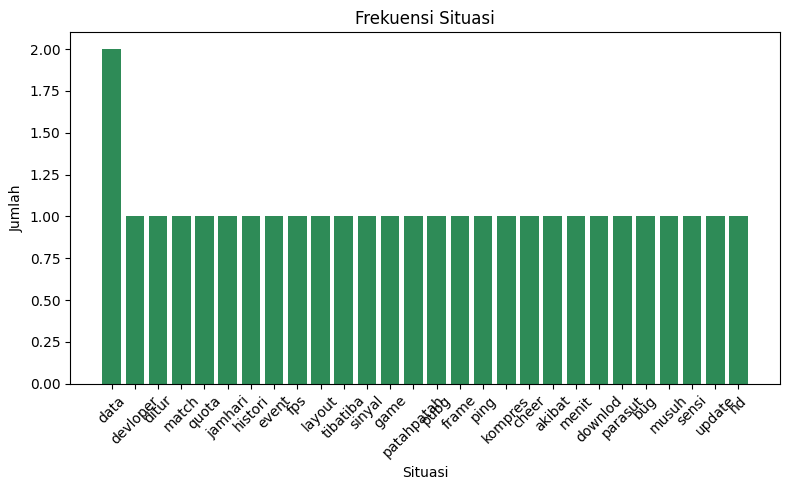

In [10]:
plot_counter(event_counter, "Frekuensi Situasi", "Situasi", "seagreen")

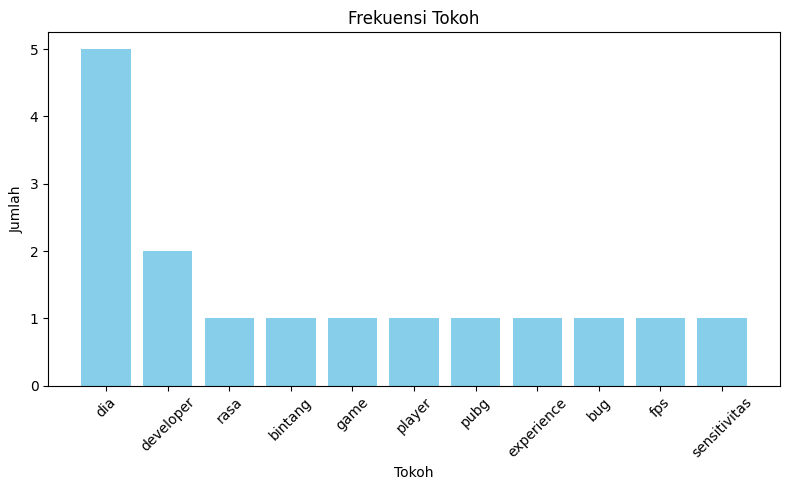

In [11]:
plot_counter(person_counter, "Frekuensi Tokoh", "Tokoh", "skyblue")

In [ ]:
!pip install wordcloud

### 🌫️Visualisasi Word Cloud

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Buat DataFrame
df = pd.DataFrame(extracted_review)

# Fungsi ekstraksi kata
def extract_terms(series):
    terms = []
    for item in series:
        if isinstance(item, str) and item.strip().lower() != "tidak ditemukan":
            terms.extend([term.strip() for term in item.split(',')])
    return terms

# Ekstrak kata dari masing-masing kategori
issues = extract_terms(df["Problem (Issue)"])
persons = extract_terms(df["Who (Person)"])
events = extract_terms(df["Event (Situation)"])

# Fungsi untuk menampilkan word cloud
def show_wordcloud(words, title):
    if not words:
        print(f"Tidak ada data untuk {title}")
        return
    text = ' '.join(words)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

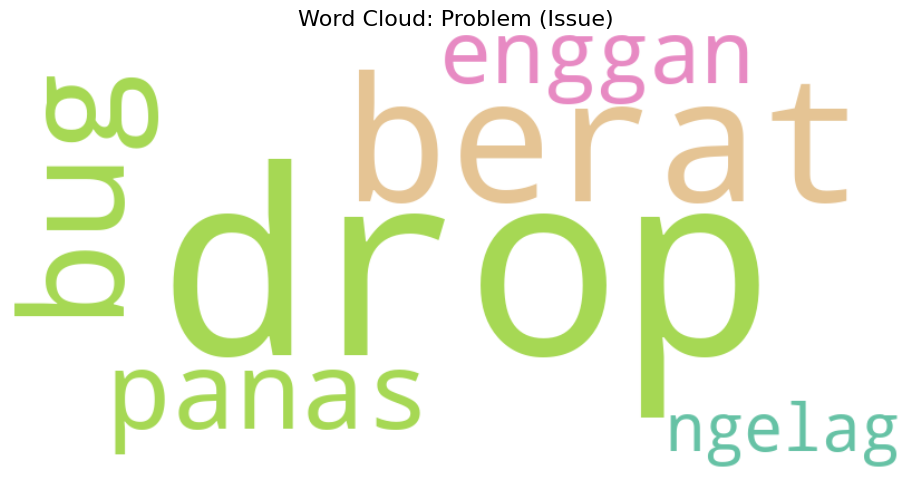

In [ ]:
show_wordcloud(issues, "Word Cloud: Problem (Issue)")

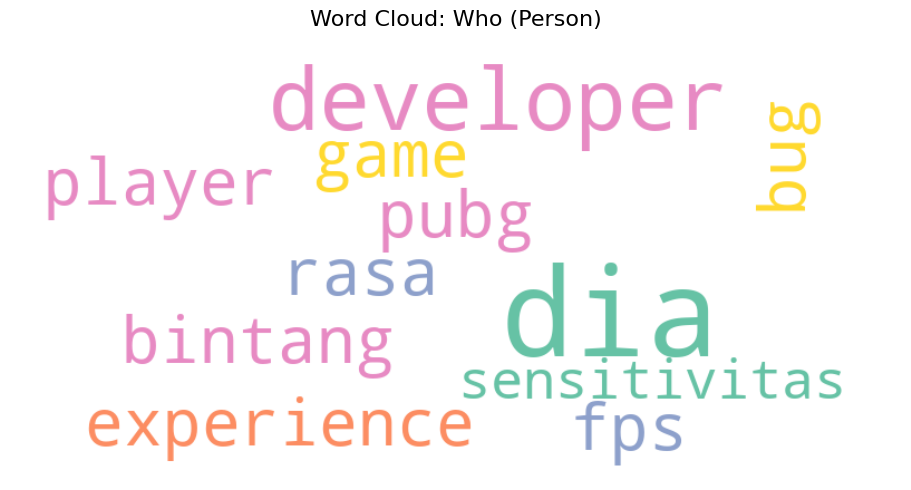

In [ ]:
show_wordcloud(persons, "Word Cloud: Who (Person)")

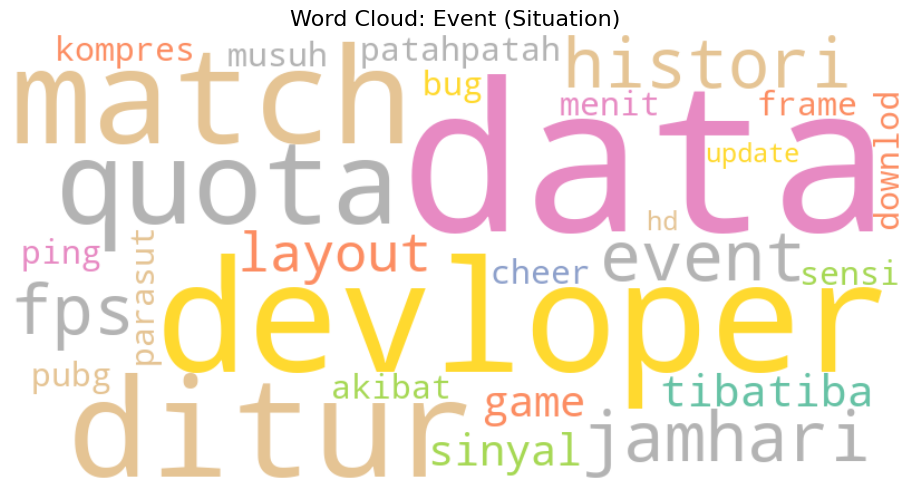

In [ ]:
show_wordcloud(events, "Word Cloud: Event (Situation)")

# 📘 Soal 7: Evaluasi dan Kesimpulan
## 🎯 Tujuan
evaluasi terhadap proses yang telah dilakukan

## 1️⃣ Apa tantangan yang Anda hadapi selama proses scraping data dari Google Play Store?

Tantangan saya ketika proses scrapping data dari Google Play Store adalah:
* Data yang tidak selalu bersih: Banyak review yang tidak lengkap, tidak relevan, atau mengandung teks informal/slang.
* Bahasa campuran: Beberapa review dalam bahasa campuran (misal: Indonesia + Inggris), menyulitkan analisis lanjutan.

## 2️⃣ Apa kesulitan dalam melakukan analisis sentimen otomatis dan ekstraksi entitas dengan aturan produksi?

Kesulitan saya dalam melakukan analisis sentimen otomatis dan ekstraksi entitas dengan aturan produksi adalah:
* Kesulitan menangkap konteks: Analisis sentimen otomatis sulit memahami sarkasme, ironi, atau konteks spesifik domain.
* Variasi bahasa dan typo: Banyak review mengandung typo, singkatan, atau slang yang tidak bisa dikenali model secara default.
* Aturan produksi (rule-based NER) terbatas: Mengandalkan aturan regex atau pola tertentu kurang fleksibel dan gagal menangkap entitas yang lebih kompleks atau tak terduga.
* Ketergantungan pada preprocessing: Kesalahan atau ketidakkonsistenan pada tahap tokenisasi dan normalisasi bisa menurunkan kualitas analisis.

## 3️⃣Apa rekomendasi Anda untuk meningkatkan akurasi hasil analisis ini?

Rekomendasi saya untuk meningkatkan akurasi hasil analisis ini adalah:
* Perbaiki preprocessing data, seperti normalisasi teks, penghapusan slang, dan deteksi bahasa, agar teks yang dianalisis lebih bersih dan terstandarisasi.
* Tambahkan analisis konteks menggunakan dependency parsing atau attention mechanism untuk menangkap makna kalimat yang lebih kompleks seperti sarkasme dan opini campuran.